In [1]:
# Graphical Library
import matplotlib.pyplot as plt 

# Image loading
import cv2 

# Maths
import math
import numpy as np
from scipy import ndimage

# Model Persistence
import pickle

# Iterable utils
import itertools


import keras
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
# Generate imgs
def generate_img(img, cmap=plt.get_cmap('gray')):
    plt.imshow(img, cmap=cmap)
    plt.show()

def generate_imgs(img1, img2, img3, img4):
    plt.subplot(221)
    generate_img(img1)
    plt.subplot(222)
    generate_img(img2)
    plt.subplot(223)
    generate_img(img3)
    plt.subplot(224)
    generate_img(img4)
    plt.show()

In [3]:
# load the model from disk
def load_model(filename):
    return pickle.load(open(filename, 'rb'))    

In [4]:
def get_img_filepath(writer, digit, img_option, folder='imgs', extension="jpg"):
    return f"{folder}/{img_option}/all_data/{writer}_{digit}.{extension}"

# Sanity check
print(get_img_filepath(2, 1, 'no_flash'))
print(get_img_filepath(2, 1, 'flash'))

imgs/no_flash/all_data/2_1.jpg
imgs/flash/all_data/2_1.jpg


In [5]:
def get_test_set_color(writers, digits, img_options):
    X_test, y_test = [], []
    for i in itertools.product(writers, digits, img_options):
        img_filepath = get_img_filepath(*i)

        X_test += [cv2.imread(img_filepath)]
        y_test += [i[1]]
        
    return np.array(X_test), np.array(y_test)

def get_test_set_bw(writers, digits, img_options):
    X_test, y_test = [], []
    for i in itertools.product(writers, digits, img_options):
        img_filepath = get_img_filepath(*i)

        X_test += [cv2.imread(img_filepath, cv2.IMREAD_GRAYSCALE)]
        y_test += [i[1]]
        
    return np.array(X_test), np.array(y_test)

# Sanity check
print(get_test_set_color(range(1, 2), [1, 2, 3], ['no_flash'])[0][0].shape)
print(get_test_set_bw(range(1, 2), [1, 2, 3], ['no_flash'])[0][0].shape)

(153, 153, 3)
(153, 153)


The first step will be to load the model and the images that our model is trying to recognize.

In [6]:
# Global constants
model_filename = "trained_mlp.sav"

number_of_writers = range(1, 5)
number_of_digits = range(0, 10)
img_options = ['no_flash', 'flash']

In [7]:
# Load model
model = load_model(model_filename)


In [8]:
# Load images
# X_test_color, y_test = get_test_set_color(number_of_writers, number_of_digits, img_options)

# Let us assume the black and white by now, since it is the simplest approach and it resembles the approach used for MNIST
X_test_bw, y_test = get_test_set_bw(number_of_writers, number_of_digits, img_options)
print(f"Loaded {len(y_test)} images")
[print(f"\t-Loaded image with {x.shape} px") for x in X_test_bw[1:10]];

Loaded 80 images
	-Loaded image with (151, 151) px
	-Loaded image with (153, 153) px
	-Loaded image with (159, 159) px
	-Loaded image with (141, 141) px
	-Loaded image with (148, 148) px
	-Loaded image with (164, 164) px
	-Loaded image with (160, 160) px
	-Loaded image with (190, 190) px
	-Loaded image with (187, 187) px


__Note__: Each image has a different size, which means it is necessary to resize them back to the (28x28) characteristic of the MNIST dataset. 

Before continuing we will pursue these guide with 4 main examples. We will continue with one digit from each writer: 

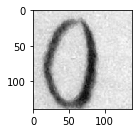

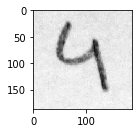

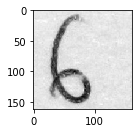

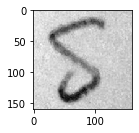

In [9]:
selected_examples = [0, 9, 53, 30]
X = X_test_bw[selected_examples]
y = y_test[selected_examples]

generate_imgs(*X)

In [10]:
def resize_imgs(imgs, dims=(28,28), interpolation=cv2.INTER_NEAREST):
    return np.array([cv2.resize(img, dims) for img in imgs])

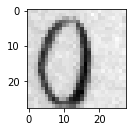

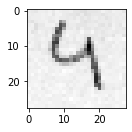

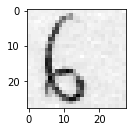

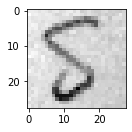

In [11]:
X_resized = resize_imgs(X)
generate_imgs(*X_resized)

In [14]:
# Expected format
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

print(f"Current format: {X_resized.shape} Vs Expected format: {X_train.shape}")
print(f"Current format: {X_resized[0].shape} Vs Expected format: {X_train[0].shape}")

Current format: (4, 28, 28) Vs Expected format: (60000, 28, 28)
Current format: (28, 28) Vs Expected format: (28, 28)


In [20]:
def predict_probabilities(x):
    # Flatten x
    number_pixels = x.shape[1] * x.shape[2]
    x = x.reshape((x.shape[0], number_pixels)).astype("float32")
    # Normalize
    x = x / 255
    probabilities = model.predict_proba(x)
    return probabilities, np.argmax(probabilities, axis=1) + 1

In [21]:
probabilities, predictions = predict_probabilities(X_resized)

In [22]:
predictions

array([3, 3, 6, 9])

In [23]:
probabilities[0] 

array([4.9336535e-07, 5.1482946e-10, 4.9521562e-01, 1.3572531e-03,
       2.7577012e-22, 2.7308255e-01, 3.4937900e-02, 2.2150281e-05,
       1.9538407e-01, 4.2342862e-08], dtype=float32)